In [60]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader,DirectoryLoader
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain_astradb import AstraDBVectorStore
from langchain_core.prompts import ChatPromptTemplate
from langchain.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import StrOutputParser
from langchain import hub
from langchain.schema import Document
from langgraph.graph import START, StateGraph, END
from typing import Literal, List
from typing_extensions import TypedDict
from dotenv import load_dotenv
import os
import pinecone
from langchain_pinecone import PineconeVectorStore
from pinecone import ServerlessSpec
from pinecone import Pinecone, ServerlessSpec

In [61]:
LANGCHAIN_TRACING_V2 = True
LANGCHAIN_ENDPOINT = "https://api.smith.langchain.com"
LANGCHAIN_API_KEY = "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"
LANGCHAIN_PROJECT = "Hackathon-Bot"

In [62]:
load_dotenv()

GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
ASTRA_API_KEY = os.getenv("ASTRA_DB_API")
DB_ENDPOINT = os.getenv("DB_ENDPOINT")
DB_ID = os.getenv("DB_ID")

In [63]:
llm = ChatGoogleGenerativeAI(api_key = GOOGLE_API_KEY, model = "gemini-1.5-flash",temperature = 1)
gemini_embedding = GoogleGenerativeAIEmbeddings(google_api_key = GOOGLE_API_KEY, model = "models/embedding-001")

In [7]:
def load_pdf(directory_path):
    # Check if the directory exists
    if not os.path.exists(directory_path):
        raise FileNotFoundError(f"Directory not found: '{directory_path}'")
    
    # Create DirectoryLoader with the given path
    loader = DirectoryLoader(directory_path, glob="*.pdf", loader_cls=PyPDFLoader)
    documents = loader.load()
    return documents

# Define the absolute path to the Data directory
directory_path = r"C:\Users\aashutosh kumar\Hackathon\Data"  # Replace with the actual path

# Load the documents
try:
    extracted_documents = load_pdf(directory_path)
    print(f"Number of documents loaded: {len(extracted_documents)}")
except FileNotFoundError as e:
    print(e)

Number of documents loaded: 911


In [8]:
def split_chunks(extracted_documents):
    splitter = RecursiveCharacterTextSplitter(chunk_size = 500,chunk_overlap = 20)
    text_chunks = splitter.split_documents(extracted_documents)
    return text_chunks

In [9]:
text_chunks = split_chunks(extracted_documents)
print(len(text_chunks))

6460


In [45]:
def ingest(status):
    vector_store = AstraDBVectorStore(token = "astracs:GideTLnkylIwDRhtYYmkbQXk:3f07cd3086c6f2970991b86f305e9abb60f57fb54eb9ce96e4da0c314473135c",
                                      api_endpoint = "https://3ee531ff-96fa-4fd6-bd08-0f7622ef1754-us-east1.apps.astra.datastax.com/",
                                      embedding = gemini_embedding,
                                      namespace = "default_keyspace",
                                      collection_name = "Hack_DB")
    is_full = status
    if is_full == None:#THIS MEANS THERE IS NO VECTORS CREATED IN DB
        inserted_ids = vector_store.add_documents(text_chunks)
    else:
        return vector_store
    
    
    return vector_store

In [64]:
pinecone_api_key = "8f20cf9f-f7cc-4d0b-ae9e-3e423fb44a0a"
from pinecone import Pinecone, ServerlessSpec
pc = Pinecone(api_key = pinecone_api_key)

In [65]:
index = pc.Index(name = "hackbot")
retriever = PineconeVectorStore(embedding = gemini_embedding,pinecone_api_key = pinecone_api_key,index_name = "hackbot")

In [24]:
# retriever.add_documents(text_chunks)

ProtocolError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [66]:
retriever = retriever.as_retriever()

In [54]:
retriever.invoke("medication for fever")

[Document(metadata={'page': 42.0, 'source': 'C:\\Users\\aashutosh kumar\\Hackathon\\Data\\8205Oxford Handbook of Clinical Medicine 10th 2017 Edition_SamanSarKo - Copy.pdf'}, page_content='thyroxine, gonadorelin or somatostatin analog ues, vasopressin, and ephedrine. Also \namiodarone, ciproﬂ  oxacin, levodopa, lisinopril, rivastigmine, ritonavir, pioglitazone, venlafaxine. At the bedside: ask about all drugs, examine all over for nodes; any signs of hyperthyroidism? Any spleno megaly? Test the urine; do \nT°, ESR, TSH, FBC, & \nblood culture. \ue057 : Antiperspirants (aluminium chloride 20%=Driclor®), sympathec-\ntomy, or iontophoresis may be tried.Fevers, rigors, sweats'),
 Document(metadata={'page': 45.0, 'source': 'C:\\Users\\aashutosh kumar\\Hackathon\\Data\\8205Oxford Handbook of Clinical Medicine 10th 2017 Edition_SamanSarKo - Copy.pdf'}, page_content='Charts:\n  •Temperature: varies during the day; a morning oral temperature >37.2°C or evening \n>37.7°C constitutes a fever. 3 Re

In [68]:
from typing import TypedDict
class GraphState(TypedDict):
  question : str
  documents : list[str]
  generation : str

In [69]:
def route(state):
    question = state["question"]
    class RouteQuery(BaseModel):
        datasource: Literal["vector-store", "out_of_context"] = Field(..., description = "For a Given User Question Find out whether to route it to vector-store or out_of_context")
    
    system ="""You are an expert at routing a user's medical question to either a vector store or an out_of_context category.
               The vector store contains documents related to medical guidelines, treatments, and healthcare practices. 
               NOTE: If a question includes specific medical terminology, disease names, or treatment protocols, route it to the vector store.
               Use the vector store for questions about symptoms, diagnoses, treatments, medications, or healthcare guidelines. 
               For general or non-medical queries, route them to out_of_context."""


    llm_router = llm.with_structured_output(RouteQuery)

    route_prompt = ChatPromptTemplate.from_messages([("system",system), ("human", "{question}")])
    question_router = route_prompt | llm_router

    response = question_router.invoke({"question" : question})
    print(response)
    if response.datasource == "out_of_context":
        print("ROUTING TO OUT_OF_CONTEXT")
        return "out_of_context"
    else:
        print("ROUTING TO VECTOR STORE")
        return "vector-store"

In [70]:
def retrieve(state):
    question = state["question"]
    docs = retriever.invoke(question)
    return {"documents" : docs}

In [71]:
def AnswerGrader(state):
    question = state["question"]
    generation = state["generation"]

    class Grade(BaseModel):
        Binary_Score: str = Field(description="Does the answer resolve the query. yes or no")

    structured_llm = llm.with_structured_output(Grade)

    system = """You are a grader assessing whether an answer effectively addresses and resolves a medical question.
                Provide a binary score: 'yes' if the answer resolves the question and 'no' if it does not."""

    
    answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ])

    grader_chain = answer_prompt | structured_llm
    response = grader_chain.invoke({"question": question, "generation": generation})

    if response.Binary_Score == "yes":
        return "useful"
    else:
        return "not useful"

In [72]:
def generation(state):
    question = state["question"]
    docs = state["documents"]
    
    prompt = hub.pull("rlm/rag-prompt", api_key = LANGCHAIN_API_KEY)
    rag_chain = prompt | llm | StrOutputParser()
    generated_text = rag_chain.invoke({"context": docs, "question": question})
    # state["generation"] = generated_text
    return {"documents": docs, "question": question, "generation": generated_text}

In [73]:
def Grade_Docs(state):    
    question = state["question"]
    documents = state["documents"]
    class Grade_Docs(BaseModel):
        binary_score : Literal["yes","no"] = Field(...,description = "Documents are relevant to the question, 'yes' or 'no'")

    system ="""You are a grader assessing the relevance of a retrieved medical document to a user's question.
               If the document contains keywords, phrases, or semantic meaning related to the medical question, grade it as relevant.
               The evaluation does not need to be overly stringent; the goal is to filter out clearly irrelevant documents.
               Provide a binary score: 'yes' if the document is relevant to the question, and 'no' if it is not."""


    grade_prompt = ChatPromptTemplate.from_messages([("system", system),("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),])

    llm_grader = llm.with_structured_output(Grade_Docs)

    retrieval_grader = grade_prompt | llm_grader

    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}

In [74]:
def transform_query(state):    
    question = state["question"]
    documents = state["documents"]

    system = """You are a question re-writer that converts an input question to a better version that is optimized \n
        for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
    re_write_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            (
                "human",
                "Here is the initial question: \n\n {question} \n Formulate only one improved question.",
            ),
        ]
    )

    question_rewriter = re_write_prompt | llm | StrOutputParser()
    revised_question = question_rewriter.invoke({"question": question})
    # state["revised_question"] = revised_question
    return {"documents": documents, "question": revised_question}

In [75]:
def decide_to_generate(state):
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [76]:
def out_of_context(State):
    question = State["question"]
    print("The given Question is Out of Context Please Ask relevant Questions related to your Medical diagnosis.")

In [77]:
workflow = StateGraph(GraphState)

workflow.add_node("out_of_context_node",out_of_context)
workflow.add_node("retrieve_node",retrieve)
workflow.add_node("grade_documents_node",Grade_Docs)
workflow.add_node("generation_node", generation)
workflow.add_node("transform_query_node", transform_query)

workflow.add_conditional_edges(START, route,{
    "vector-store" : "retrieve_node",
    "out_of_context": "out_of_context_node"
})

workflow.add_edge("out_of_context_node", END)
workflow.add_edge("retrieve_node", "grade_documents_node")

workflow.add_conditional_edges("grade_documents_node", decide_to_generate,{
    "transform_query" : "transform_query_node",
    "generate" : "generation_node"
})

workflow.add_edge("transform_query_node", "retrieve_node")

workflow.add_conditional_edges("generation_node", AnswerGrader,{
    "useful" : END,
    "not useful" : "transform_query_node"
})

app = workflow.compile()

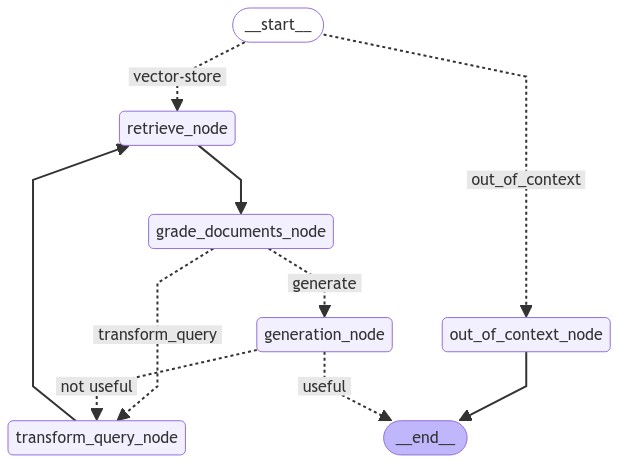

In [78]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [79]:
from pprint import pprint
inputs = {
    "question": "What to do fever?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}':")
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

ValidationError: 1 validation error for RouteQuery
datasource
  unexpected value; permitted: 'vector-store', 'out_of_context' (type=value_error.const; given=vector_store; permitted=('vector-store', 'out_of_context'))